# STUDYING OUTCOME DATA

In [91]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scale for maps
from matplotlib_scalebar.scalebar import ScaleBar
# Personalised legends for maps
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import os

import geopandas as gpd
import rasterio as rio
import fiona
import contextily
import osmnx
from shapely import geometry

In [ ]:
# Set working directory
os.chdir("/Users/unaioyon/Desktop/masters_thesis/data/fra")

In [ ]:
# Import data
dv3f = gpd.read_file("dv3f_new_variables/dv3f_modified.geojson")

In [ ]:
# Obtain basic information from the dataset
dv3f.info()
print(dv3f.crs)

# 1. D3VF: real-estate transaction data

# 2. Accidents data

In [92]:
# Import arrondissement, IRIS (2022 for consistency with slow zones but they are equivalent)and slow zone data
arr = gpd.read_file("arrondissements/arrondissements.shp")
iris = gpd.read_file("iris/geo/iris_paris_2022/1_DONNEES_LIVRAISON_2022-05-00266/IRIS-GE_2-0_SHP_LAMB93_D075-2022/IRIS_GE.SHP")
zones = gpd.read_file("zones_30/zones-30.shp")

In [94]:
# Change the CRSs
arr.to_crs("4326", inplace = True)
iris.to_crs("4326", inplace = True)
zones.to_crs("4326", inplace = True)

In [ ]:
# Import data
acc = pd.read_csv("accidents/final/accidents_final.csv", low_memory = False)

In [ ]:
# Check missing values
acc[["lat", "long", "latitude", "longitude"]].isna().sum()

There are 12,736 NAs in the cleaned data, which leaves me with 82.93% of the original 103,817 (computed from the table in the thesis) database, or 85,538 observations.

In [ ]:
# Create a dataframe from the lat/long pairs
acc_geo = gpd.GeoDataFrame(acc,
                          geometry = gpd.points_from_xy(x =  acc["longitude"],
                                                       y = acc["latitude"]),
                          crs = "EPSG:4326")

#### CAVEAT!
The "accidents_final.csv" database includes some accidents which fall outside of the administrative boundaries of Paris. These obserations are either wrongly geocoded or badly classified as within the département de Paris. In either case, they are dropped and the eventual geodataframe ends up with 85,011 observations with a valid geometry.

In [ ]:
# Keep accidents inside the administrative boundaries of Paris
acc_geo_paris = acc_geo[acc_geo["geometry"].within(arr.dissolve().loc[0,"geometry"])]

In [ ]:
# How many do I have left?
acc_geo_paris.shape[0] # 85,011

## 2.1 Classify accidents as belonging to IRIS, slow zones and arrondissements

In [ ]:
acc_geo_paris.info()

In [ ]:
# Creating the variables
acc_geo_paris.insert(53, "slow_zone", pd.Series([], dtype = "object"))
acc_geo_paris.insert(54, "slow_zone_year", pd.Series([], dtype = "object"))
# acc_geo_paris.insert(57, "slow_zone_intersect", pd.Series([]))
acc_geo_paris.insert(55, "arr", pd.Series([], dtype = "object"))
acc_geo_paris.insert(56, "arr_code", pd.Series([], dtype = "object"))
# acc_geo_paris.insert(58, "arr_intersect", pd.Series([]))
acc_geo_paris.insert(57, "iris", pd.Series([], dtype = "object"))
acc_geo_paris.insert(58, "iris_code", pd.Series([], dtype = "object"))
acc_geo_paris.insert(59, "iris_name", pd.Series([], dtype = "object"))
# acc_geo_paris.insert(59, "iris_intersect", pd.Series([]))

In [100]:
%%time
# Classifying SLOW ZONES
# There are 9 zones with missing geometries, so these ones will not have any transaction inside
zones_non_na = zones[zones["geometry"].isna() == False].copy()

for i in zones_non_na.index:
    acc_geo_paris.loc[acc_geo_paris["geometry"].within(zones.loc[i, "geometry"]), "slow_zone"] = zones.loc[i, "nom_zca"]
    acc_geo_paris.loc[acc_geo_paris["geometry"].within(zones.loc[i, "geometry"]), "slow_zone_year"] = zones.loc[i, "year"]
    
# Add a dummy equal to 1 if inside a slow zone
acc_geo_paris.insert(52, "slow_zone_d", pd.Series([], dtype = "object"))
acc_geo_paris["slow_zone_d"] = 0
acc_geo_paris.loc[acc_geo_paris["slow_zone"].isna() == False, "slow_zone_d"] = 1

/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CPU times: user 28.3 s, sys: 98.5 ms, total: 28.4 s
Wall time: 28.4 s


/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [105]:
# Count number of NAs
print(acc_geo_paris["slow_zone"].notna().sum()) # 21,125 (i.e. 24.84% of transactions inside of slow zones)
print(acc_geo_paris.loc[acc_geo_paris["slow_zone"].isna() == False, "slow_zone_year"].isna().sum()) # 4,456 without year of implementation

21125
4456


In [107]:
# All zones have at least an accident regardless of the year
print(len(zones_non_na["nom_zca"].unique()) == len(acc_geo_paris["slow_zone"].unique())-1)
print(len(zones_non_na["nom_zca"].unique()) - (len(acc_geo_paris["slow_zone"].unique())-1))

True
0


In [108]:
%%time
# Classifying ARRONDISSEMENTS

for i in arr.index:
    acc_geo_paris.loc[acc_geo_paris["geometry"].within(arr.loc[i, "geometry"]), "arr"] = arr.loc[i, "c_ar"]
    acc_geo_paris.loc[acc_geo_paris["geometry"].within(arr.loc[i, "geometry"]), "arr_code"] = arr.loc[i, "c_arinsee"]

/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CPU times: user 8.2 s, sys: 58.9 ms, total: 8.26 s
Wall time: 8.26 s


In [109]:
# As expected, all inside the arrondissements by construction after I drop the ones that are outside
print(acc_geo_paris[["arr", "arr_code"]].isna().sum())
acc_geo_paris.loc[acc_geo_paris["arr"].isna() == True, "geometry"]

arr         0
arr_code    0
dtype: int64


GeoSeries([], Name: geometry, dtype: geometry)

In [110]:
%%time
# Classifying IRIS

for i in iris.index:
    acc_geo_paris.loc[acc_geo_paris["geometry"].within(iris.loc[i, "geometry"]), "iris"] = iris.loc[i, "IRIS"]
    acc_geo_paris.loc[acc_geo_paris["geometry"].within(iris.loc[i, "geometry"]), "iris_code"] = iris.loc[i, "CODE_IRIS"]
    acc_geo_paris.loc[acc_geo_paris["geometry"].within(iris.loc[i, "geometry"]), "iris_name"] = iris.loc[i, "NOM_IRIS"]

/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/anaconda3/envs/geo_env/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

CPU times: user 5min 12s, sys: 958 ms, total: 5min 13s
Wall time: 5min 13s


In [111]:
# Checking out the result
print(len(acc_geo_paris["iris"].unique())-1) # ALL IRIS have transactions
print(acc_geo_paris["iris"].isna().sum()) # 51 accidents are outside of IRIS lol. Tiny error, all in the frontiers

992
51


<AxesSubplot: >

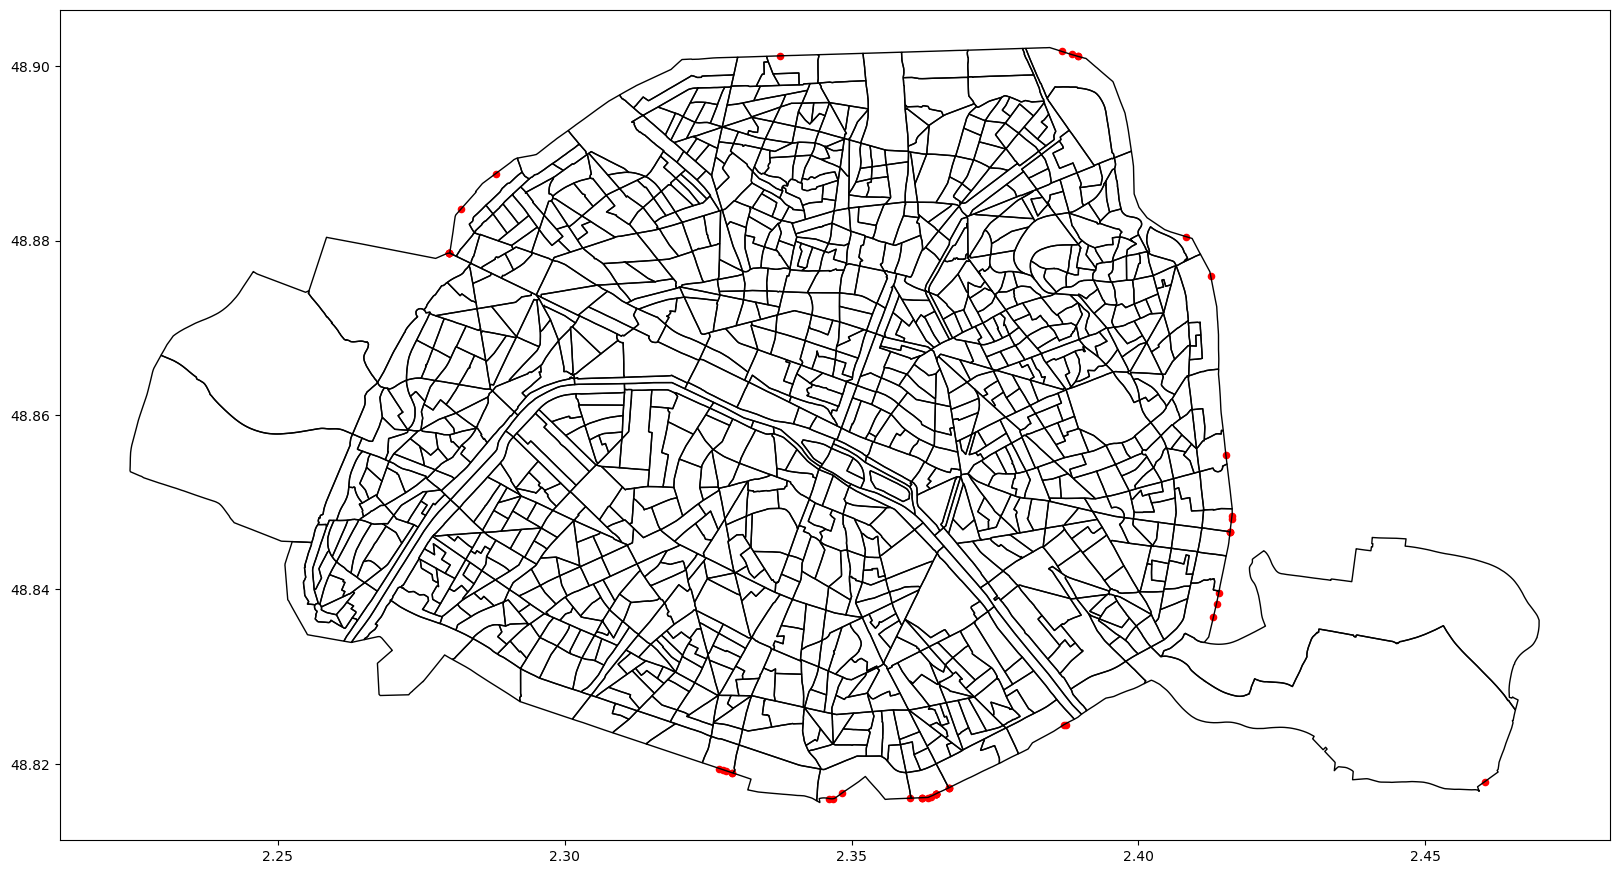

In [114]:
# See where these accidents are
fig, ax = plt.subplots(1, figsize = (20,20))
iris.boundary.plot(linewidth = 1, color = "black", ax = ax)
acc_geo_paris[acc_geo_paris["iris"].isna()].plot(ax = ax, markersize = 20, color = "red")


In [115]:
# Save the geodataframe
acc_geo_paris.to_file("accidents/final/accidents_final_geo.geojson")

<AxesSubplot: >

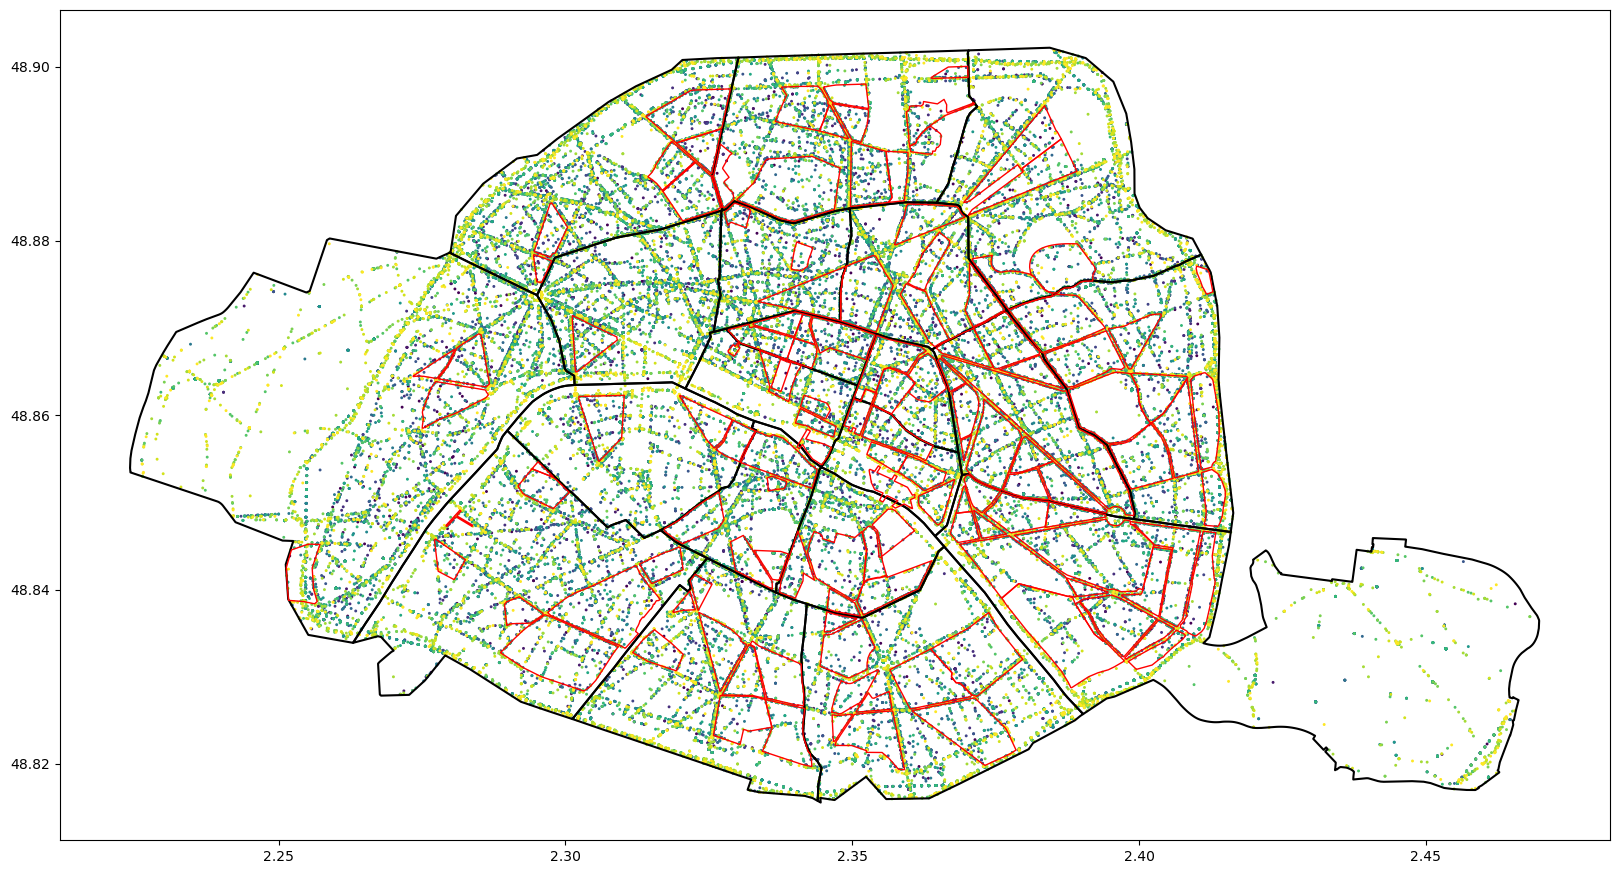

In [103]:
# Plot the accidents to have a feeling of what is going on
fig, ax = plt.subplots(1, figsize = (20, 20))
arr.boundary.plot(linewidth = 1.5, ax=ax, color = "black")
zones.boundary.plot(linewidth = 1, ax = ax, color = "red")
acc_geo_paris.plot(ax = ax, markersize = 1.2, column = "an")